# PCA and autoencoders

This notebook explores dimensionality reduction through autoencoding of a classic dataset.

Let's start be loading our dependencies:

In [83]:
# Numpy is our primary dependency
import numpy as np

# Import datasets from scikit-learn only to get the iris data set
from sklearn import datasets

# We will need some plotting too
import matplotlib.pyplot as plt

## The Dataset

We will use the iris data set for this exercise:

In [2]:
# Load iris data set
iris = datasets.load_iris()

# Extract data and feature names
data = iris.data
feature_names = iris.feature_names

# Similarly for labels and label names
labels = iris.target
label_names = iris.target_names

The dataset describes four characteristics of a sample of three different species of iris flowers. Our aim is to reduce the four dimension to two, so that we can make a scatter plot of the data set.

The four features are:

In [41]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

The three species labels are:

In [43]:
label_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='<U10')

### Pre-processing of data

We will need to pre-process the data in various ways. For PCA, we will need all features to be centered (i.e. with mean zero) and with unit standard deviation.

For the autoencoding section, we will need to make sure that all values are between 0 and 1. We will need these data in transposed form as well.

In [76]:
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)

maxs = np.amax(data, axis=0)
mins = np.amin(data, axis=0)


# Data used for PCA
PCAdata = (data - means) / stds

# Data used for autoencoder
AEdata = (data - mins) / (maxs - mins)
AEdata = AEdata.transpose()

## Principal component analysis

The covariance matrix for the centered data set can now be calculated as essentially the Gramian of the data matrix:

In [7]:
cov = np.matmul(PCAdata.transpose(), PCAdata) / (PCAdata.shape[0] - 1)

Diagonalize the covariance matrix to get the eigenvalues and corresponding principal axes:

In [8]:
eig, axes = np.linalg.eig(cov)

Check the eigenvalues:

In [9]:
eig

array([ 2.93035378,  0.92740362,  0.14834223,  0.02074601])

Since the two largest eigenvalues are rather large compared to the last two, a two-dimensional plot should cover a reasonable amount of the variation in the data set.

Now calculate the principal components corresponding to the two largest eigenvalues:

In [10]:
pc2d = np.matmul(PCAdata, axes[:, 0:2])

Now we can plot the dimensionally reduced dataset, using these principal components:

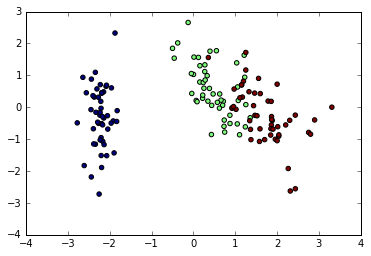

In [11]:
# Grab each component
pc1 = np.array(pc2d[:, 0].transpose())
pc2 = np.array(pc2d[:, 1].transpose())

# Plot
plt.scatter(pc1, pc2, c=labels)
plt.show()

Each color corresponds to a species of iris.

## Autoencoders

PCA is an example of an *autoencoder*.

An autoencoder consists of two parts: A *coder* and a *decoder*. The coder transforms the origin data points into a feature space of lower dimension than the original dataset. The decoder then transforms from the low dimension space back into the origin set of dimensions. The aim is for the decoder to get as close to the original data as possible.

When the coder and decoder are *linear transformations*, the resulting optimal autoencoder is equivalent to PCA.

But what if we add non-linearities? The situation is similar to adding an activation function to a neural net, and indeed that is what we will do here. The resulting neural net is shown in the figure below. This has a minimum number of layers.

![Structure of a shallow neural net autoencoder](autoencoder.png)

## The neural net model

But we could add several additional layers in the coder and decoder. In this case we get a *deep autoencoder*. Here, we will make each two layers deep, such that:

- The coder transforms from 4 to 3 to 2 dimensions.
- The decoder transforms from 2 to 3 to 4 dimensions.

I.e. our model will be the one depicted below:

![The autoencoder model we will use](deep_autoencoder.png)

### Activation functions

We will use a number of activation functions to study their differences. Each function will return the activation values as well as the derivatives.

In [190]:
# No activation function
def linear(x):
    linear_grad = np.ones(x.shape)
    return x, linear_grad

# Sigmoid
def sigmoid(x):
    sigmoid = 1 / (1 + np.exp(-x))
    sigmoid_grad = sigmoid * (1 - sigmoid)
    return sigmoid, sigmoid_grad

# ReLU
def relu(x):
    relu = np.maximum(x, np.zeros(x.shape))
    relu_grad = np.ones(x.shape) * (x > 0)
    return relu, relu_grad

### Neural network math

We will represent our neural network as a list of dictionaries, each corresponding to a layer of neurons:

In [78]:
# Make a new layer
def new_layer(dim_in, dim_out):
    weights = np.random.rand(dim_out, dim_in) - 0.5
    bias = np.random.rand(dim_out, 1) - 0.5
    
    return {
        'weights': weights,
        'bias': bias,
        'activations': np.zeros((dim_out, AEdata.shape[1])),
        'act_grad': np.zeros((dim_out, AEdata.shape[1])),
        'errors': np.zeros((dim_out, AEdata.shape[1])),
        'weights_grad': np.zeros(weights.shape),
        'bias_grad': np.zeros(bias.shape)
    }

# Our specific models hyperparameters
def initialize_model():
    return [new_layer(4, 3), new_layer(3, 2), new_layer(2, 3), new_layer(3, 4)]

We need to be able to forward propagate values ...

In [169]:
def forward_propagate(layers, inputs, activation_function):
    for layer in layers:
        zs = np.matmul(layer['weights'], inputs) + layer['bias']
        activations, act_grad = activation_function(zs)
        layer['activations'] = activations
        layer['act_grad'] = act_grad
        inputs = activations

... and backpropagate values:

In [170]:
def backward_propagate(layers, inputs, outputs):    
    # Initiate errors for the last layer (normalized)
    errors = (layers[-1]['activations'] - outputs)
    
    # Go backwards through the layers
    for layer_number, layer in reversed(list(enumerate(layers))):
        layer['errors'] = errors
        
        # Calculate Hadamard product between errors and activation gradients
        hadamard = errors * layer['act_grad']
        
        # Get activations of previous layer - if at the first layer use input
        if layer_number == 0:
            last_activations = inputs
        else:
            last_activations = layers[layer_number - 1]['activations']
        
        # Calculate derivatives of weights
        weights_grad = np.matmul(hadamard, last_activations.transpose()) / inputs.shape[1]
        layer['weights_grad'] = weights_grad
        
        # Calculate derivatives of biases
        bias_grad = hadamard.sum(axis=1).reshape(layer['bias'].shape) / inputs.shape[1]
        layer['bias_grad'] = bias_grad
        
        # Backpropagate errors, unless we're at the first layer
        if layer_number != 0:
            errors = np.matmul(layer['weights'].transpose(), hadamard)

And we need to be able to update weights and biases based on the results of the backpropagation:

In [171]:
def gradient_descent(layers, learning_rate):
    for layer in layers:
        layer['weights'] = layer['weights'] - layer['weights_grad'] * learning_rate
        layer['bias'] = layer['bias'] - layer['bias_grad'] * learning_rate

Finally, we need the value of the error function to visualize training:

In [172]:
def error_function(layers):
    errors = layers[-1]['errors']
    e_squared = errors ** 2
    return e_squared.sum() / errors.shape[1]

## Training the autoencoder

The following function will initialize and train our autoencoder:

In [178]:
def trainAE(activation_function, learning_rate, epochs):
    # Initialize model
    layers = initialize_model()
    
    # Array of errors
    error_history = []
    
    # Run through the epochs
    for epoch in range(epochs):
        forward_propagate(layers, AEdata, activation_function)
        backward_propagate(layers, AEdata, AEdata)
        gradient_descent(layers, learning_rate)
        error_history.append(error_function(layers))
    
    # Return trained model, and error_history for plotting
    return layers, error_history

### Linear autoencoder

First, let's train a linear autoencoder.

The error history is plotted below.

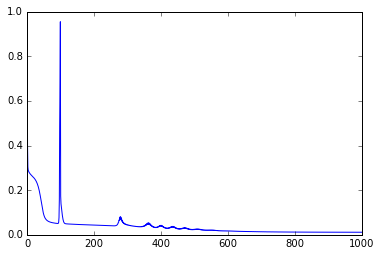

In [193]:
layers, error_history = trainAE(linear, .4, 1000)

# Plot error history
plt.plot(range(1000), error_history)
plt.show()

Let's look at the encoded coordinates:

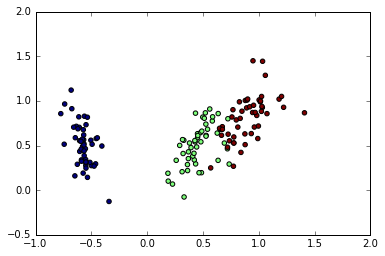

In [194]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=labels)
plt.show()

Since a linear autoencoder is equivalent to PCA, it is not surprising, that this looks similar (but may be rotated/inverted).

### Sigmoid autoencoder

Same procedure for the sigmoid activation function:

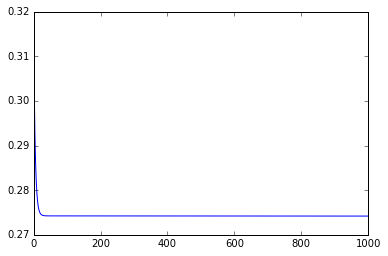

In [203]:
layers, error_history = trainAE(sigmoid, 1, 1000)

# Plot error history
plt.plot(range(1000), error_history)
plt.show()

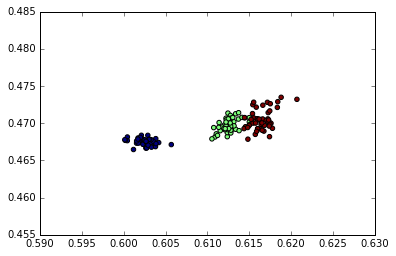

In [204]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=labels)
plt.show()

Perhaps somewhat surprisingly, this generally seems to perform a bit worse than the linear autoencoder.

### ReLU autoencoder

And finally the ReLU activation function:

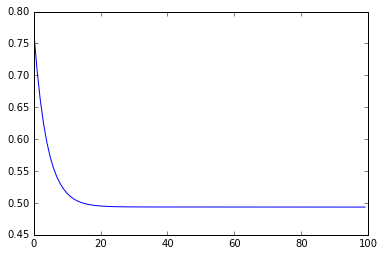

In [220]:
layers, error_history = trainAE(relu, .1, 100)

# Plot error history
plt.plot(range(100), error_history)
plt.show()

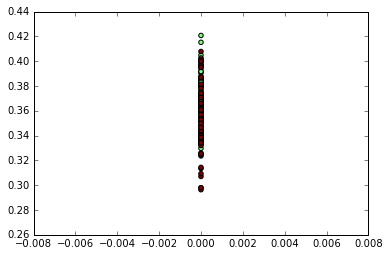

In [221]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=labels)
plt.show()

This has a tendency to squash the dimensions :-/ So probably not a good pick.